In [1]:
!pip install torch torchvision

In [5]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device = ",DEVICE)

import multiprocessing
num_workers = multiprocessing.cpu_count()
print(f"Number of available workers: {num_workers}")

Using Device =  cpu
Number of available workers: 2


In [7]:
df = pd.read_csv("Train_data.csv")
df = df.dropna()  # must do
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30798 entries, 0 to 31042
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LATITUDE     30798 non-null  float64
 1   LONGITUDE    30798 non-null  float64
 2   CTDPRS       30798 non-null  float64
 3   CTDTMP       30798 non-null  float64
 4   CTDSAL       30798 non-null  float64
 5   depth_m      30798 non-null  float64
 6   SA           30798 non-null  float64
 7   CT           30798 non-null  float64
 8   sound_speed  30798 non-null  float64
dtypes: float64(9)
memory usage: 2.3 MB


In [8]:
X = df.drop(columns=["sound_speed"])
y = df.sound_speed
print(X.shape,y.shape)

(30798, 8) (30798,)


In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=42)
print(X_train.shape,X_test.shape)

(24638, 8) (6160, 8)


`Modelling`

In [10]:
class DNN(nn.Module):
  def __init__(self,input_size):
    super(DNN,self).__init__()
    self.fc = nn.Sequential(
        # Input Block
        nn.Linear(in_features=input_size,out_features=320),
        nn.ReLU(),
        nn.BatchNorm1d(320),
        # Hidden 1 (320 -> 160)
        nn.Linear(in_features=320,out_features=160),
        nn.ReLU(),
        nn.BatchNorm1d(160),
        # Hidden 2 (160 -> 160)
        nn.Linear(in_features=160,out_features=160),
        nn.ReLU(),
        nn.BatchNorm1d(160),
        # Hidden 3 (160 -> 80)
        nn.Linear(in_features=160,out_features=80),
        nn.ReLU(),
        nn.BatchNorm1d(80),
        # Hidden 4 (80 -> 40)
        nn.Linear(in_features=80,out_features=40),
        nn.ReLU(),
        nn.BatchNorm1d(40),
        # Out Block
        nn.Linear(in_features=40,out_features=1)
    )
  def forward(self,x):
    return self.fc(x)


In [11]:
from torchsummary import summary
model = DNN(X_train.shape[1])  # Instantiation
summary(model,(X_train.shape[1],),device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 320]           2,880
              ReLU-2                  [-1, 320]               0
       BatchNorm1d-3                  [-1, 320]             640
            Linear-4                  [-1, 160]          51,360
              ReLU-5                  [-1, 160]               0
       BatchNorm1d-6                  [-1, 160]             320
            Linear-7                  [-1, 160]          25,760
              ReLU-8                  [-1, 160]               0
       BatchNorm1d-9                  [-1, 160]             320
           Linear-10                   [-1, 80]          12,880
             ReLU-11                   [-1, 80]               0
      BatchNorm1d-12                   [-1, 80]             160
           Linear-13                   [-1, 40]           3,240
             ReLU-14                   

- Total training = `n_folds * epochs` -> `5*20=100`
- Science behind batch_size here -> `~30M records / 65536 = 457.76` so ,similarly `30k / 64 = ~468` closer.

## *Cross Validation*

In [14]:
# for verifying the hyper parameters.

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
all_histories, fold_metrics = [], []
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = int(X_train.shape[0]/457.76)

for fold_num, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nFold {fold_num + 1}/{n_folds}")

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Standardization
    scaler = StandardScaler()
    X_train_fold_std = scaler.fit_transform(X_train_fold)
    X_val_fold_std = scaler.transform(X_val_fold)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold_std, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32)
    X_val_tensor   = torch.tensor(X_val_fold_std, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val_fold.values, dtype=torch.float32)


    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False)

    # Model, optimizer, loss
    model = DNN(input_size=X_train_tensor.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)
    criterion = nn.L1Loss()  # MAE (same as Keras loss)

    # Train
    history = train_model(model, optimizer, criterion, train_loader, val_loader, patience=5, min_delta=0.1, max_epochs=20, device=device)
    all_histories.append(history)

    # Final evaluation
    final_rmse, final_r2 = history["val_rmse"][-1], history["val_r2"][-1]
    fold_metrics.append((final_rmse, final_r2))
    print(f"\nFold {fold_num + 1} RMSE: {final_rmse:.4f}, R2: {final_r2:.4f}")


Fold 1/5
Epoch: 0


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.25it/s]


Epoch: 1


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 131.58it/s]


Epoch: 2


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 172.62it/s]


Epoch: 3


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 198.76it/s]


Epoch: 4


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.75it/s]


Epoch: 5


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 189.22it/s]


Epoch: 6


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 147.14it/s]


Epoch: 7


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 152.87it/s]


Epoch: 8


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 188.82it/s]


Epoch: 9


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.65it/s]


Epoch: 10


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.87it/s]


Epoch: 11


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.83it/s]


Epoch: 12


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 131.45it/s]


Epoch: 13


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 193.37it/s]


Epoch: 14


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 159.86it/s]


Epoch: 15


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 199.54it/s]


Epoch: 16


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 166.33it/s]


Epoch: 17


Training Batch: 100%|██████████| 372/372 [00:03<00:00, 106.58it/s]


Epoch: 18


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.20it/s]


Epoch: 19


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 195.09it/s]



Early stopping at epoch 20

Fold 1 RMSE: 2.1428, R2: 0.9919

Fold 2/5
Epoch: 0


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 195.56it/s]


Epoch: 1


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 167.65it/s]


Epoch: 2


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 134.96it/s]


Epoch: 3


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 159.67it/s]


Epoch: 4


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.37it/s]


Epoch: 5


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 199.06it/s]


Epoch: 6


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 185.44it/s]


Epoch: 7


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 190.68it/s]


Epoch: 8


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 137.15it/s]


Epoch: 9


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 183.76it/s]


Epoch: 10


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 190.01it/s]


Epoch: 11


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 198.23it/s]


Epoch: 12


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 192.70it/s]


Epoch: 13


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 195.67it/s]


Epoch: 14


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 136.92it/s]


Epoch: 15


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 195.45it/s]


Epoch: 16


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.73it/s]



Early stopping at epoch 17

Fold 2 RMSE: 3.4972, R2: 0.9801

Fold 3/5
Epoch: 0


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.19it/s]


Epoch: 1


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.15it/s]


Epoch: 2


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 165.93it/s]


Epoch: 3


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 151.85it/s]


Epoch: 4


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.75it/s]


Epoch: 5


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 200.15it/s]


Epoch: 6


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 189.23it/s]


Epoch: 7


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.37it/s]


Epoch: 8


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 155.89it/s]


Epoch: 9


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 162.60it/s]


Epoch: 10


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 183.88it/s]


Epoch: 11


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 183.74it/s]


Epoch: 12


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 158.55it/s]


Epoch: 13


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 136.06it/s]


Epoch: 14


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 157.56it/s]


Epoch: 15


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.80it/s]


Epoch: 16


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 193.95it/s]


Epoch: 17


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 194.66it/s]



Early stopping at epoch 18

Fold 3 RMSE: 1.7556, R2: 0.9947

Fold 4/5
Epoch: 0


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 199.79it/s]


Epoch: 1


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 150.90it/s]


Epoch: 2


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 166.22it/s]


Epoch: 3


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 198.87it/s]


Epoch: 4


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 201.04it/s]


Epoch: 5


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 191.71it/s]


Epoch: 6


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 186.15it/s]


Epoch: 7


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 129.84it/s]


Epoch: 8


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 188.85it/s]


Epoch: 9


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 188.85it/s]


Epoch: 10


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 145.46it/s]


Epoch: 11


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 200.29it/s]


Epoch: 12


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 160.30it/s]


Epoch: 13


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 162.57it/s]


Epoch: 14


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 196.31it/s]


Epoch: 15


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 196.94it/s]


Epoch: 16


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 196.67it/s]


Epoch: 17


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 175.92it/s]



Early stopping at epoch 18

Fold 4 RMSE: 2.4138, R2: 0.9892

Fold 5/5
Epoch: 0


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 145.51it/s]


Epoch: 1


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 167.13it/s]


Epoch: 2


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 179.13it/s]


Epoch: 3


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 195.94it/s]


Epoch: 4


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 190.74it/s]


Epoch: 5


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 186.97it/s]


Epoch: 6


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 136.61it/s]


Epoch: 7


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 179.96it/s]


Epoch: 8


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 163.76it/s]


Epoch: 9


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 153.36it/s]


Epoch: 10


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 184.35it/s]


Epoch: 11


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 132.04it/s]


Epoch: 12


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 189.19it/s]


Epoch: 13


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 195.63it/s]


Epoch: 14


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 200.75it/s]


Epoch: 15


Training Batch: 100%|██████████| 372/372 [00:01<00:00, 203.32it/s]


Epoch: 16


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 156.90it/s]


Epoch: 17


Training Batch: 100%|██████████| 372/372 [00:02<00:00, 136.78it/s]



Early stopping at epoch 18

Fold 5 RMSE: 2.6492, R2: 0.9871


In [15]:
BATCH_SIZE

53

In [ ]:
X_train_fold.shape,X_val_fold_std.shape

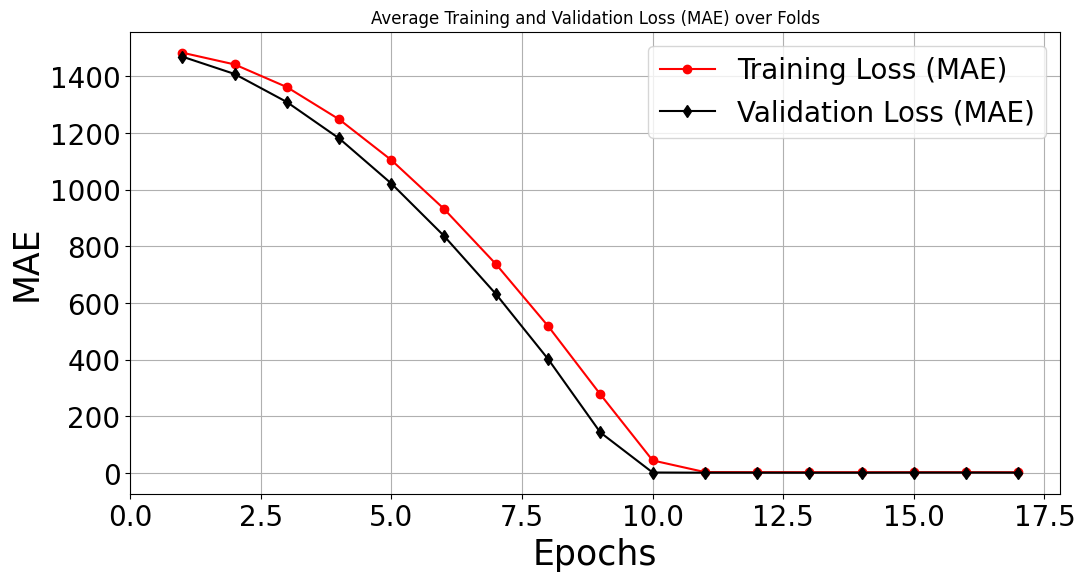

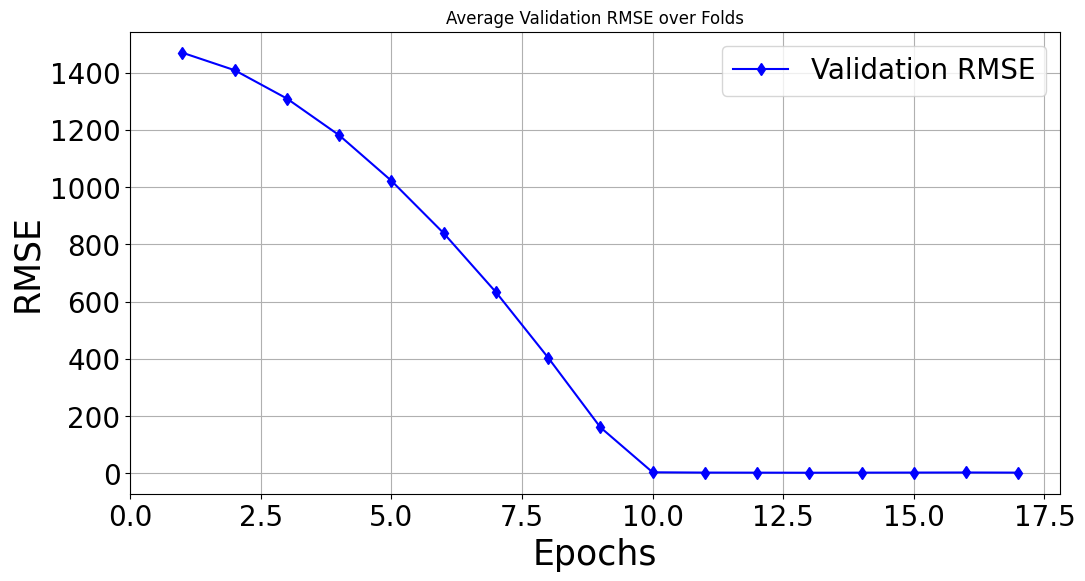

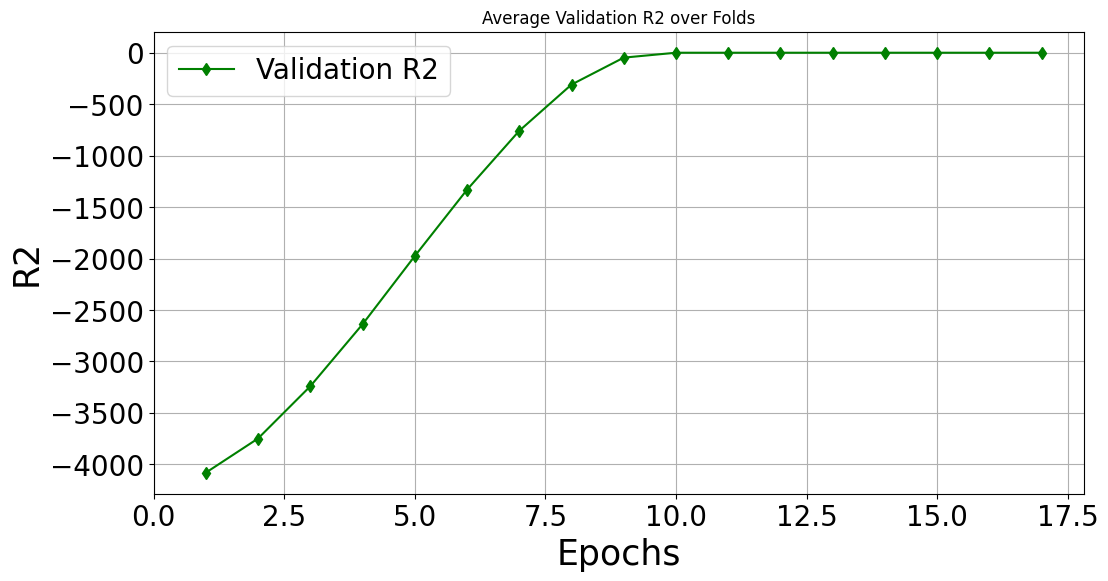

In [ ]:
# Find the minimum number of epochs completed by all folds
min_epochs = min(len(history['val_loss']) for history in all_histories)

# Prepare data structures for storing averaged metrics
average_train_loss = [0] * min_epochs
average_val_loss = [0] * min_epochs
average_val_rmse = [0] * min_epochs
average_val_r2 = [0] * min_epochs

# Aggregate the metrics
for history in all_histories:
    for i in range(min_epochs):
        average_train_loss[i] += history['train_loss'][i]
        average_val_loss[i] += history['val_loss'][i]
        average_val_rmse[i] += history['val_rmse'][i]
        average_val_r2[i] += history['val_r2'][i]


# Average the metrics
average_train_loss = [x / len(all_histories) for x in average_train_loss]
average_val_loss = [x / len(all_histories) for x in average_val_loss]
average_val_rmse = [x / len(all_histories) for x in average_val_rmse]
average_val_r2 = [x / len(all_histories) for x in average_val_r2]

# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, min_epochs + 1), average_train_loss, 'o-', color="r", label='Training Loss (MAE)')
plt.plot(range(1, min_epochs + 1), average_val_loss,'d-', color="k", label='Validation Loss (MAE)')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('MAE', fontsize=25)
plt.legend(loc="best",fontsize=20)
plt.xticks(np.arange(0, min_epochs + 1, 2.5), fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title('Average Training and Validation Loss (MAE) over Folds')
# plt.savefig(r'D:\Nik\Paper1\PaperPlot\lc_com_dnn.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting RMSE
plt.figure(figsize=(12, 6))
plt.plot(range(1, min_epochs + 1), average_val_rmse, 'd-', color="b", label='Validation RMSE')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('RMSE', fontsize=25)
plt.legend(loc="best",fontsize=20)
plt.xticks(np.arange(0, min_epochs + 1, 2.5), fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title('Average Validation RMSE over Folds')
plt.show()

# Plotting R2
plt.figure(figsize=(12, 6))
plt.plot(range(1, min_epochs + 1), average_val_r2, 'd-', color="g", label='Validation R2')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('R2', fontsize=25)
plt.legend(loc="best",fontsize=20)
plt.xticks(np.arange(0, min_epochs + 1, 2.5), fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title('Average Validation R2 over Folds')
plt.show()

## *Training*

In [ ]:
def plotter(history):# Plotting Loss
  plt.figure(figsize=(12, 6))
  plt.plot(range(len(history['train_loss'])), history['train_loss'], 'o-', color="r", label='Training Loss (MAE)')
  plt.plot(range(len(history['val_loss'])), history['val_loss'],'d-', color="k", label='Validation Loss (MAE)')
  plt.xlabel('Epochs', fontsize=25)
  plt.ylabel('MAE', fontsize=25)
  plt.legend(loc="best",fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.grid()
  plt.title('Training and Validation Loss (MAE)')
  plt.show()

  # Plotting RMSE
  plt.figure(figsize=(12, 6))
  plt.plot(range(len(history['val_rmse'])), history['val_rmse'], 'd-', color="b", label='Validation RMSE')
  plt.xlabel('Epochs', fontsize=25)
  plt.ylabel('RMSE', fontsize=25)
  plt.legend(loc="best",fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.grid()
  plt.title('Validation RMSE')
  plt.show()

  # Plotting R2
  plt.figure(figsize=(12, 6))
  plt.plot(range(len(history['val_r2'])), history['val_r2'], 'd-', color="g", label='Validation R2')
  plt.xlabel('Epochs', fontsize=25)
  plt.ylabel('R2', fontsize=25)
  plt.legend(loc="best",fontsize=20)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.grid()
  plt.title('Validation R2')
  plt.show()

In [13]:
def train_model(model, optimizer, criterion, train_loader, val_loader, patience=5, min_delta=0.1, max_epochs=20, device="cpu"):
    '''
    Returns the training history
    '''
    best_val_loss = float("inf")
    patience_counter = 0
    history = {"train_loss": [], "val_loss": [], "val_mae": [], "val_mse": [], "val_rmse": [], "val_r2": []}

    for epoch in range(max_epochs):
        print(f"Epoch: {epoch}")
        model.train()
        running_loss = 0.0
        for xb, yb in tqdm(train_loader,desc="Training Batch"):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_mae, val_mse, val_rmse, val_r2 = 0.0, 0.0, 0.0, 0.0, 0.0
        total_samples = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze()
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)

                # Metrics
                val_mae += torch.mean(torch.abs(preds - yb)).item() * xb.size(0)
                mse = torch.mean((preds - yb) ** 2)
                val_mse += mse.item() * xb.size(0)
                val_rmse += torch.sqrt(mse).item() * xb.size(0)

                # Calculate R2 score (using manual calculation as r2_score is not a standard torch metric)
                # This calculation is for a single batch, will average later
                mean_y = torch.mean(yb)
                ss_total = torch.sum((yb - mean_y) ** 2)
                ss_residual = torch.sum((yb - preds) ** 2)
                r2 = 1 - (ss_residual / ss_total) if ss_total > 0 else 0.0 # Avoid division by zero
                val_r2 += r2.item() * xb.size(0)
                total_samples += xb.size(0)


        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)
        val_mse /= len(val_loader.dataset)
        val_rmse /= len(val_loader.dataset)
        val_r2 /= len(val_loader.dataset)


        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(val_loss)
        history["val_mae"].append(val_mae)
        history["val_mse"].append(val_mse)
        history["val_rmse"].append(val_rmse)
        history["val_r2"].append(val_r2)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    return history

In [ ]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train,y_train)
X_test_scaled = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train_scaled,dtype = torch.float32)  # type conversion important, tensor and float32
X_test_tensor = torch.tensor(X_test_scaled,dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values,dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values,dtype = torch.float32)

In [ ]:
BATCH_SIZE = int(X_train.shape[0]/457.76)
# Dataloader
train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,num_workers=num_workers,shuffle=True)
val_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,num_workers=num_workers,shuffle=False)

In [ ]:
full_model = DNN(X_train.shape[1])
lossfn = nn.L1Loss()
optim = torch.optim.Adam(full_model.parameters(),lr=0.0012)
history = train_model(
    full_model,
    optim,
    lossfn,
    train_loader,
    val_loader
)

Epoch: 0

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 112.45it/s]


Epoch: 1

Training Batch: 100%|██████████| 465/465 [00:03<00:00, 119.05it/s]


Epoch: 2

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 97.68it/s] 


Epoch: 3

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 115.95it/s]


Epoch: 4

Training Batch: 100%|██████████| 465/465 [00:03<00:00, 118.12it/s]


Epoch: 5

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 94.50it/s] 


Epoch: 6

Training Batch: 100%|██████████| 465/465 [00:03<00:00, 116.39it/s]


Epoch: 7

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 104.48it/s]


Epoch: 8

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 100.14it/s]


Epoch: 9

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 111.64it/s]


Epoch: 10

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 93.15it/s] 


Epoch: 11

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 115.89it/s]


Epoch: 12

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 112.29it/s]


Epoch: 13

Training Batch: 100%|██████████| 465/465 [00:05<00:00, 83.13it/s] 


Epoch: 14

Training Batch: 100%|██████████| 465/465 [00:04<00:00, 108.24it/s]



Early stopping at epoch 15


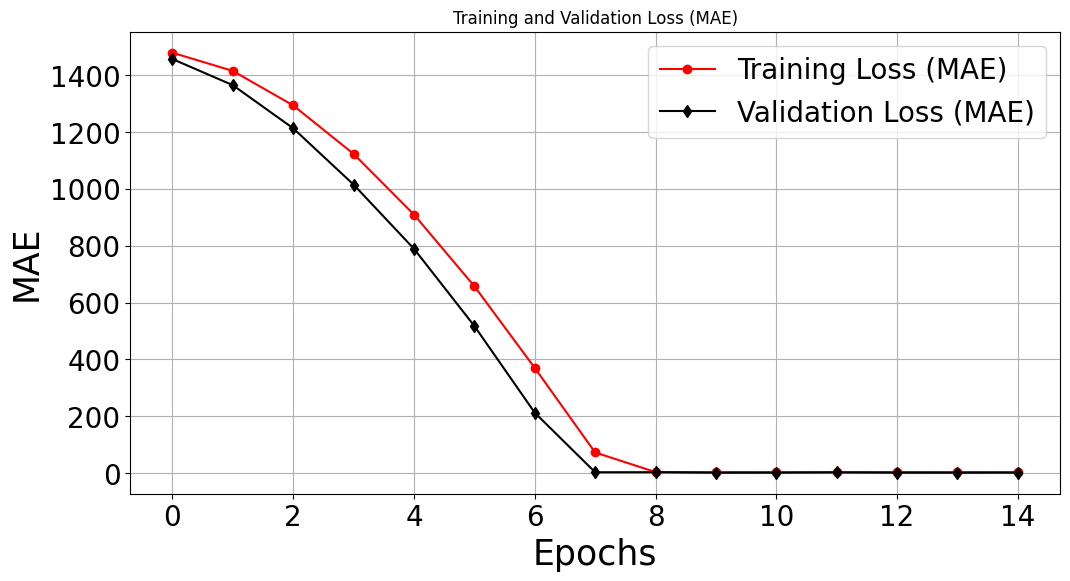

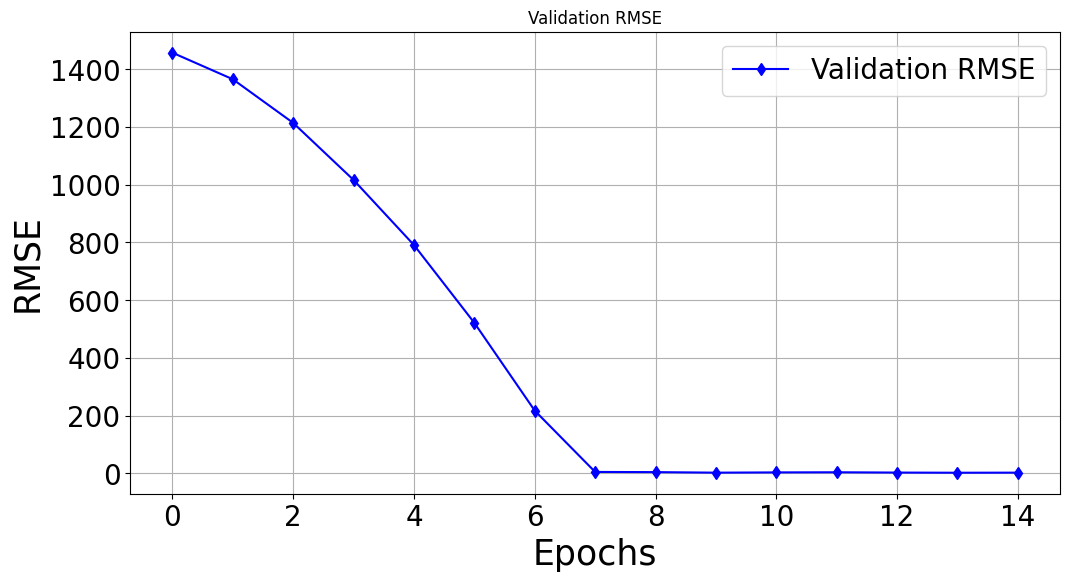

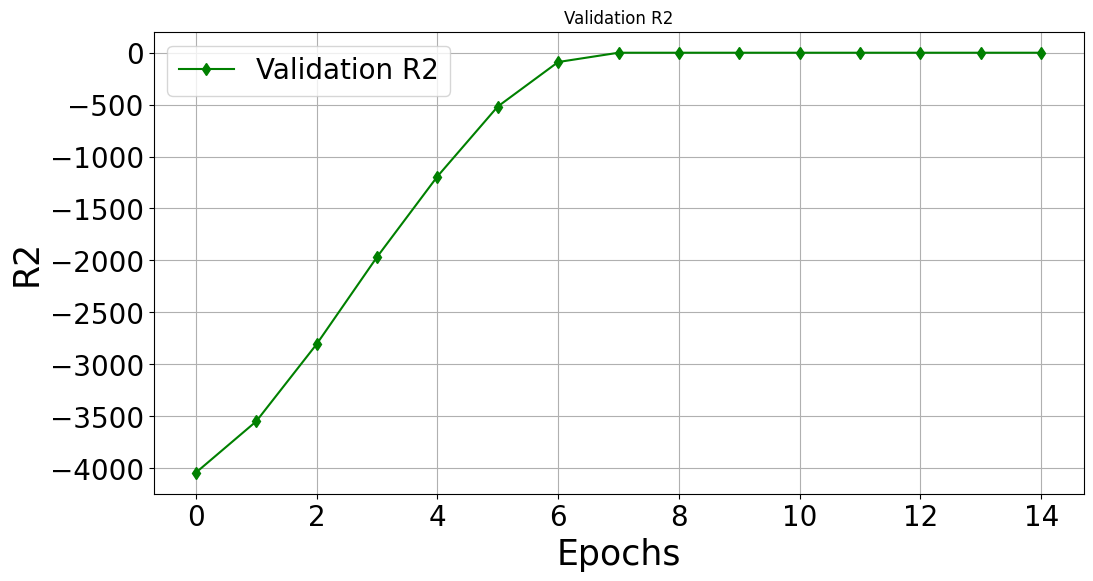

In [ ]:
plotter(history)

## *Prediction*

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

X = scaler.fit_transform(X,y)
X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y.values,dtype=torch.float32)

In [ ]:
full_model.eval()
with torch.no_grad():
  y_pred = full_model(X).squeeze()

In [ ]:
y_pred.shape,y.shape

(torch.Size([30798]), torch.Size([30798]))

In [ ]:
rmse = np.sqrt(mean_squared_error(y,y_pred))
r2 = r2_score(y,y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R2_score: {r2:.2f}")

RMSE: 2.29
R2_score: 0.99


In [ ]:
y_df = pd.DataFrame(y.numpy(), columns=['Actual_Sound_Speed'])
y_pred_df = pd.DataFrame(y_pred.numpy(), columns=['Predicted_Sound_Speed'])
display(y_df.head())
display(y_pred_df.head())

,Actual_Sound_Speed
0,1496.124023
1,1497.367554
2,1502.399170
3,1499.119263
4,1499.720337


,Predicted_Sound_Speed
0,1495.442139
1,1496.284668
2,1500.769043
3,1497.909668
4,1498.488159


In [ ]:
torch.save(full_model.state_dict(), 'full_model.pth')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30798 entries, 0 to 31042
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LATITUDE     30798 non-null  float64
 1   LONGITUDE    30798 non-null  float64
 2   CTDPRS       30798 non-null  float64
 3   CTDTMP       30798 non-null  float64
 4   CTDSAL       30798 non-null  float64
 5   depth_m      30798 non-null  float64
 6   SA           30798 non-null  float64
 7   CT           30798 non-null  float64
 8   sound_speed  30798 non-null  float64
dtypes: float64(9)
memory usage: 2.3 MB


In [ ]:
res = pd.concat([df[['LATITUDE', 'LONGITUDE']], y_df, y_pred_df], axis=1)
res.to_csv("Predicted_Speed.csv", index=False)
display(res.head())

,LATITUDE,LONGITUDE,Actual_Sound_Speed,Predicted_Sound_Speed
0,-2.3390,141.1528,1496.124023,1495.442139
1,-2.2497,141.2340,1497.367554,1496.284668
2,-2.1690,141.4777,1502.399170,1500.769043
3,-2.0842,141.7432,1499.119263,1497.909668
4,-2.0038,141.9930,1499.720337,1498.488159
